# 🤖 Model Training: Religious Hate Speech Classifier

This notebook fine-tunes a transformer-based model to detect **religious hate speech** in user comments.

The training data comes from our `data.ipynb` preprocessing pipeline, which extracted and weakly labeled comments based on:
- Keyword-based religious mention detection
- Toxicity thresholds

We train on a **balanced dataset** to improve detection of minority class (`hate = 1`) and evaluate model performance on both validation and test splits.

---

## 🧪 Notebook Overview

1. 📥 Load balanced train/val/test splits
2. 🔤 Tokenize using Hugging Face tokenizer
3. 🏗️ Fine-tune transformer (starting with a small model for fast experimentation)
4. 📈 Evaluate metrics: accuracy, precision, recall, F1, confusion matrix
5. 💾 Save trained model for use on Gnoto or downstream inference

---


In [1]:
# ✅ Install if missing
!pip install transformers scikit-learn --quiet

# 📚 Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Load balanced dataset
train_df = pd.read_csv("../data/train_balanced.csv")
val_df = pd.read_csv("../data/val_balanced.csv")
test_df = pd.read_csv("../data/test_balanced.csv")

print("✅ Dataset loaded")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(train_df.sample(3))


Do not use pip without activating a virtual environment first!
Otherwise, you might break your default Python environment and not be able to start Jupyter again.
Check the Documentation on how to deal with virtual environments:
🗀 / Documentation / 10_Envs_and_kernels.ipynb
✅ Dataset loaded
Train: 142994 | Val: 9613 | Test: 9614
                                                    text  toxicity  \
79718  NO!\nHE WANTS OUT OF JAIL!!!\nDENY THAT POS AN...     0.525   
31699  Bill Maher’s show on September 29th featured t...     0.000   
7732   I would take the opposite tack and advise that...     0.000   

       severe_toxicity  obscene  threat  insult  identity_attack  \
79718            0.025      0.0    0.25     0.2           0.3375   
31699            0.000      0.0    0.00     0.0           0.0000   
7732             0.000      0.0    0.00     0.0           0.0000   

       sexual_explicit  mentions_religion  religious_hate  label  
79718              0.0               True        

## 🔤 Tokenization with Hugging Face Tokenizer

We tokenize the text using a pretrained tokenizer compatible with our selected model.  
We'll use [`prajjwal1/bert-tiny`](https://huggingface.co/prajjwal1/bert-tiny) — a lightweight BERT variant for fast testing and prototyping.

Later on Gnoto, we can easily switch to a more powerful model like `microsoft/deberta-v3-small` without changing the code logic.


In [2]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# ✅ Choose model
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Dataset wrapper for PyTorch
class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=256)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# ✅ Prepare datasets
train_data = CommentDataset(train_df['text'], train_df['label'])
val_data = CommentDataset(val_df['text'], val_df['label'])
test_data = CommentDataset(test_df['text'], test_df['label'])

# ✅ Loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

print("✅ Tokenization complete")


✅ Tokenization complete


## 🧠 Model Setup and Optimizer

We load a lightweight transformer model (`prajjwal1/bert-tiny`) for fast experimentation.  
This model will be fine-tuned on our balanced religious hate speech dataset using a binary classification head.

We use the `AdamW` optimizer, commonly used for transformer-based models, and push the model to GPU if available (CPU otherwise).


In [3]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW


# ✅ Load model with classification head (binary)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("🖥️ Running on:", device)

# ✅ Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🖥️ Running on: cuda


## 🏋️ Training Loop (1 Epoch)

We'll train the model using standard PyTorch for 1 quick epoch.  
This is just to verify that everything works before scaling it up on GPU (e.g., on Gnoto).

During each batch:
- We move inputs to the selected device
- Compute loss
- Backpropagate
- Step optimizer

We also evaluate the model on the validation set at the end of the epoch using accuracy and F1 score.


In [4]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# ✅ One quick epoch
EPOCHS = 1

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    print(f"\n🚀 Epoch {epoch + 1}/{EPOCHS}")

    for batch in tqdm(train_loader, desc="Training"):
        # Move to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    print(f"📉 Avg Training Loss: {avg_loss:.4f}")

    # ✅ Evaluation on validation set
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)
    print(f"✅ Val Accuracy: {val_acc:.4f} | F1 Score: {val_f1:.4f}")

    model.train()



🚀 Epoch 1/1


Training: 100%|██████████| 8938/8938 [01:47<00:00, 82.91it/s]


📉 Avg Training Loss: 0.2726
✅ Val Accuracy: 0.8831 | F1 Score: 0.4718


## 🧪 Final Evaluation on Test Set

After training and validation, we now evaluate the model's performance on the test set.  
We’ll compute:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix

This helps us understand how well the model generalizes to unseen religious hate speech examples.


📊 Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.98      0.89      0.93      8938
        Hate       0.35      0.77      0.48       676

    accuracy                           0.88      9614
   macro avg       0.67      0.83      0.71      9614
weighted avg       0.94      0.88      0.90      9614



/opt/jlab-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


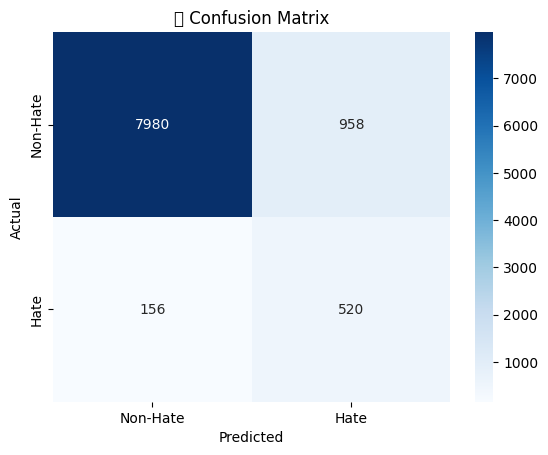

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Inference
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(batch["labels"].cpu().numpy())

# ✅ Metrics
print("📊 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Non-Hate", "Hate"]))

# ✅ Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧩 Confusion Matrix")
plt.show()

## 💾 Save Trained Model and Tokenizer

We now save the fine-tuned model and tokenizer locally so that it can be:
- Reloaded for inference
- Uploaded to Gnoto for full-scale training
- Shared with teammates or deployed later

This will create a folder containing:
- Model weights (`pytorch_model.bin`)
- Config and tokenizer files


In [6]:
from transformers import AutoTokenizer

# 📁 Save folder path
save_path = "../models/bert-tiny-hate"

# 💾 Save model + tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to: {save_path}")


✅ Model and tokenizer saved to: ../models/bert-tiny-hate


In [7]:
overlap = set(train_df['text']) & set(test_df['text'])
print(f"⚠️ Overlapping comments: {len(overlap)}")

⚠️ Overlapping comments: 0
